## Latest Version of Post_processing

It is for data saved at different times.

In [1]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LsqFit
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 1


In [2]:
e = -1
m = 1

1

In [3]:
include("aux_functions_vlasov.jl")

In [4]:

file_name = "Results/ltd_landau_try2000_401_alp3_n2_Th3.jld2"



data = load(file_name);
run_name = data["run_name"]
p_Ini = data["p_Ini"]
@show (Nx, dx, Np, dp) = data["par_grid"]
@show (t_i, t_f, M, M_g, dt) = data["par_evolv"]

Lx = (Nx-1)*dx
Lp = (Np-1)*dp/2
κ = 2π/Lx

@show Lx, Lp, κ

x = [(i-1)*dx for i in 1:Nx]
p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

dT = dt * (M-1) / (M_g-1)


M_g = 501 



v = zeros(Nx*(Np+1),M_g)

for j in 1:M_g
    tiempo = @sprintf("%05d", j)
    v[:,j] = data["u/u_$tiempo"]
end

(Nx, dx, Np, dp) = data["par_grid"] = (2000, 0.1, 401, 0.005)
(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)
(Lx, Lp, κ) = (199.9, 1.0, 0.03143164235707647)


In [5]:
plots = true
animation = true

true

In [6]:
if plots 
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:(M_g)
        plt = plot!(1e2*v[Nx*Np+1:end,j].+ofset*j)
    end
    plt
    png("electric_field_" * run_name)
end

In [7]:
if plots
    F = reshape(v[1:Nx*Np,:],(Nx,Np,M_g));

    #plot(F[Nx÷2,:,1])
    #plot!(F[Nx÷2,:,501])
    #plot_matrix(F[1:2:end,1:2:end,1]) #sparse version
    plot_matrix(F[:,:,1])
    png("initial_dist_" * run_name)
end

In [8]:
if plots
    plot_matrix(F[:,:,end], title="t=$t_f")
    png("final_dist_" * run_name)
end

In [9]:
if plots
    heatmap(F[:,:,end],
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function at t = $(t_f)"
    )

    png("final_conf_heat_" * run_name)
end

┌ Info: Saved animation to 
│   fn = /home/oreula/Julia/Vlasov/Distr_funct_cutltd_landau_try2000_401_alp3_n2_Th3.gif
└ @ Plots /home/oreula/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/oreula/Julia/Vlasov/Distr_funct_cutltd_landau_try2000_401_alp3_n2_Th3.gif")
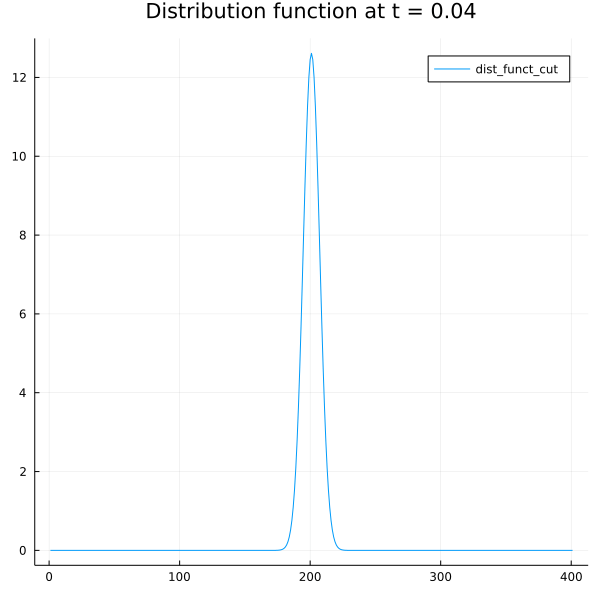

In [10]:
if animation
    anim = @animate for j = 1:5:M_g
        plot(F[Nx÷8,:,j]
        ,title = "Distribution function at t = $(dT*j)"
        ,label = "dist_funct_cut"
    )
    end

     
    gif(anim, "Distr_funct_cut"  * run_name * ".gif", fps = 5)
end

┌ Info: Saved animation to 
│   fn = /home/oreula/Julia/Vlasov/Distr_funct_ltd_landau_try2000_401_alp3_n2_Th3.gif
└ @ Plots /home/oreula/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/oreula/Julia/Vlasov/Distr_funct_ltd_landau_try2000_401_alp3_n2_Th3.gif")
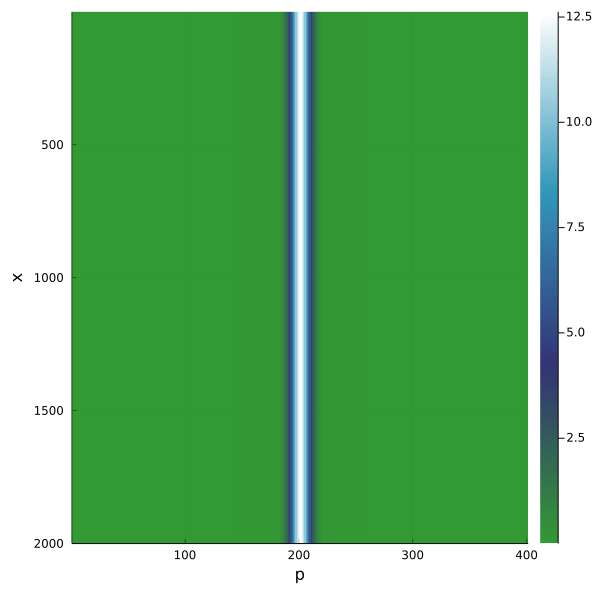

In [11]:
if animation
    anim = @animate for j = 1:50:M_g
        heatmap(F[:,:,j]
        #,c = cgrad([:blue,:white,:red])
        ,fc = :ocean
        ,linealpha = 0.8, fillalpha=0.8
        ,yflip = true
        ,xlabel = "p", ylabel = "x"
        #,title = "Distribution function at t = $(dT*j)"
    )
    end

     
    gif(anim, "Distr_funct_"  * run_name * ".gif", fps = 5)
end

In [12]:
ρ_f = zeros(Nx)
E_f = zeros(Nx)
E_i = v[Nx*Np+1:end,1]
ϕ_f = zeros(Nx)
S_f = zeros(Nx)

j = 90

get_density!(v[:,j], ρ_f, (Nx, dx, Np, dp, m, e))
Q = get_total_charge(ρ_f, (Nx, dx))
println("n0 = $(Q/Lx)")
get_ϕ!(ϕ_f, ρ_f .+ Q/e/Lx, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[Nx*Np+1:end,j], label="E_final"
    )

    png("Efield_th$(nthreads())_" * run_name)
end


n0 = -1.000500250125063


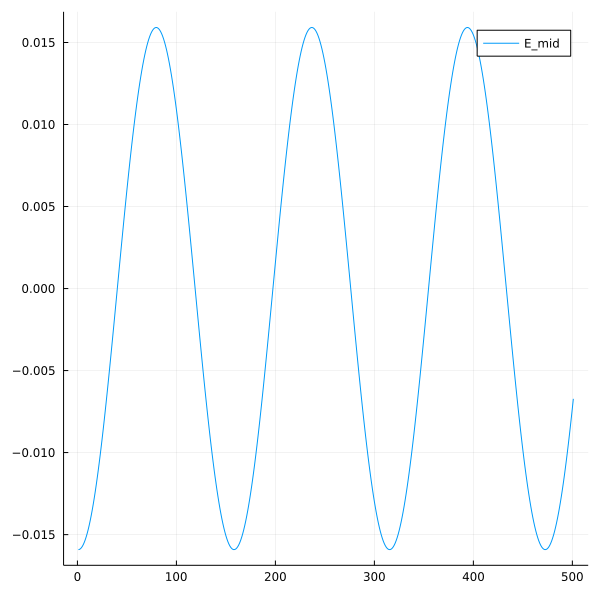

In [13]:
plot(v[Nx*Np+Nx÷8,:], label="E_mid")

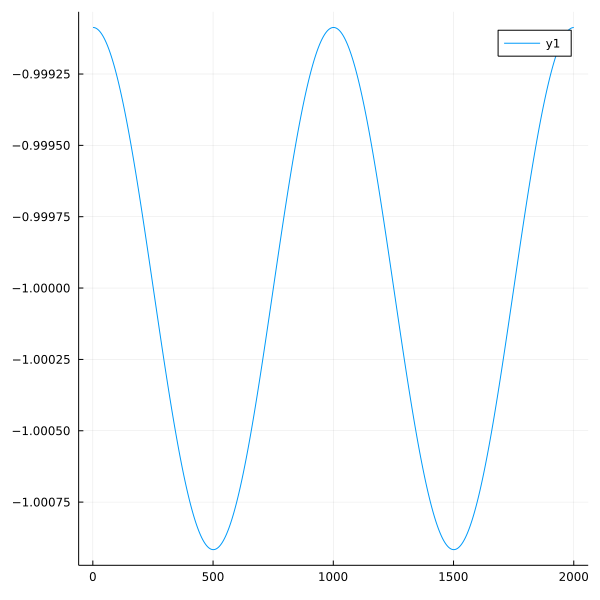

In [14]:
plot(ρ_f)

In [15]:
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
Q_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
E_K = zeros(Nx)
P = zeros(Nx)
ρ = zeros(Nx)
S = zeros(Nx)

for j in 1:M_g
    Energy_K[j]  = sum(get_K_energy!(v[:,j],E_K,(Nx, dx, Np, dp)))*dx
    Energy_E[j]  = get_E_energy(v[:,j],(Nx, dx, Np, dp))
    EField_T[j] = sum(v[Nx*Np+1:end,j])*dx
    p_T[j] = sum(get_momentum!(v[:,j],P,(Nx, dx, Np, dp)))*dx

    get_density!(v[:,j], ρ, (Nx, dx, Np, dp, m, e))
    get_current!(v[:,j], S, (Nx, dx, Np, dp, v, m, e))
    Q_T[j] = get_total_charge(ρ,(Nx, dx))
    S_T[j] = sum(S)/Nx/Q_T[j]
end

In [16]:

if plots 
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T .- e*Lx, label="charge")
    plot!(subplot=4, S_T, label="Total Current")

    png("total_conf_" * run_name)
end

GKS: Possible loss of precision in routine SET_WINDOW


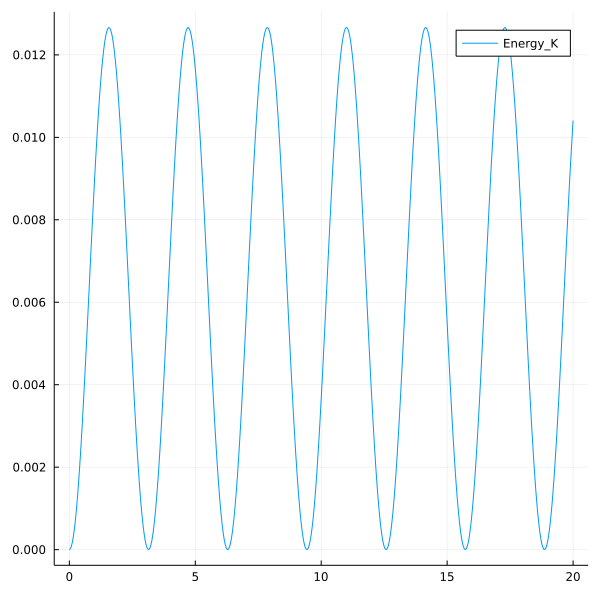

In [17]:
t_series = [dt*(i-1)*((M-1)÷(M_g-1)) for i in 1:M_g];
#Plots.scatter(t_series,(Energy_K .- Energy_K[1]), label="Energy_K")
plot(t_series,(Energy_K .- Energy_K[1]), label="Energy_K")

In [18]:
p0 = [2.910944*10^(-2); 1.004621307]
@. model(x, p) = p[1]*cos(x*p[2])^2 #* exp(-x*p[3]) #*cos(x*p[5] + p[6])

model (generic function with 1 method)

In [19]:
t_series = [dt*(i-1)*((M-1)÷(M_g-1)) for i in 1:M_g];
fit = curve_fit(model, t_series, Energy_E, p0);
fit.param

2-element Vector{Float64}:
 0.012664650807392602
 0.9992219211655119

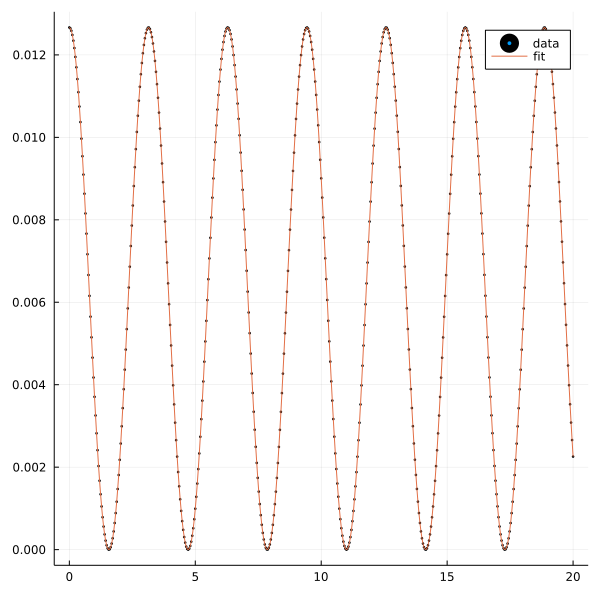

In [20]:
Plots.scatter(t_series, Energy_E,label="data",markersize=1)
#plot!(t_series, model(t_series, fit.param))
plot!(t_series, fit.param[1]*cos.(fit.param[2]*t_series).^2,label="fit")

## Finally it is working!

Fit for undamped **ltd_landau_try2000_401_alp3_n2_Th3.jld2** with parameters: 

(Nx, dx, Np, dp) = data["par_grid"] = (2000, 0.1, 401, 0.005)

(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)

(Lx, Lp, κ) = (199.9, 1.0, 0.03143164235707647)



$p1 = 0.012664650807392602 $, $p2 = 0.9992219211655119$ for $E_E(t) = p1\; cos(p2*t)^2$

